In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# spacy for lemmatization
import spacy

!pip install pyLDAvis
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Demoji (Delete emoji)
!pip install demoji
import demoji
demoji.download_codes()

# Spell correction
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

... OK (Got response in 0.35 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df=pd.read_csv('/content/drive/MyDrive/NLP Group Project/DATASET/20201113_152646_covid_tweets_1000.csv')
df.head(5)

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags
0,shadybrady224,poker dealer/player. 3rd party voter. 2 party ...,"St Paul, MN",1756,1678,22171,2013-04-05 05:00:35,2020-11-13 15:26:23,837,The “90% efficacy rate” of the Pfizer vaccine ...,[]
1,GCee_A,unashamed .\n\n🎨 : @Cruddy_doods,More Kumasi than Accra,1603,1045,25054,2011-07-22 22:41:10,2020-11-13 15:26:23,19,I don’t mean to overshare but two of my dad’s ...,[]
2,Manfr3d_,↗A.B.U Zaria📚 ↗Hausa/Yoruba ↗Runway model ↗Eve...,"Zaria, Nigeria",2965,2939,38037,2017-02-27 21:25:11,2020-11-13 15:26:23,1181,BREAKING: The Egyptian FA confirms Mo Salah ha...,[]
3,Santanumalbum,Adopt a #Dog or #Cat from a shelter - Bring mo...,"Long Island, New York",4751,2438,116503,2013-02-01 16:46:24,2020-11-13 15:26:23,9,Compass in #Advent. \n\nOur lives are being tu...,"[{'text': 'Advent', 'indices': [31, 38]}, {'te..."
4,KingAbdulahIII,Half drunk man. President of The United States...,White House - Lahore,246,130,7556,2020-01-29 17:57:46,2020-11-13 15:26:23,1181,BREAKING: The Egyptian FA confirms Mo Salah ha...,[]


In [4]:
# Remove URL

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text'] = df['text'].apply(lambda x : remove_URL(x))

In [5]:
# Remove html tags

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

In [6]:
# Remove emojis

def remove_emojis(text):
  new_text = demoji.replace(text, "")
  return new_text

df['text'] = df['text'].apply(lambda x: remove_emojis(x))

In [7]:
# Remove mentions and hashtag

def remove_mention_hashtag(text):
    text=re.sub(r'@\w+','',text)        # remove mentions
    text=re.sub(r'#\w+','',text)        # remove hashtag
    return text

df['text']=df['text'].apply(lambda x: remove_mention_hashtag(x))

In [8]:
# Remove Emails

def remove_emails(text):
  email = re.compile(r'\S*@\S*\s?')
  return email.sub(r'', text)

df['text']=df['text'].apply(lambda x : remove_emails(x))

In [9]:
# Remove new line characters

def remove_newline(text):
  newline = re.compile(r'\n+')
  return newline.sub(r'', text)

df['text']=df['text'].apply(lambda x : remove_newline(x))

In [10]:
# Remove extra white space left while removing stuff

def remove_space(text):
    whitespace_remove = re.compile(r'\s+')
    return whitespace_remove.sub(r' ', text)

df["text"]=df["text"].apply(lambda x: remove_space(x))

In [11]:
df["text"].head(5)

0    The “90% efficacy rate” of the Pfizer vaccine ...
1    I don’t mean to overshare but two of my dad’s ...
2    BREAKING: The Egyptian FA confirms Mo Salah ha...
3    Compass in . Our lives are being turned upside...
4    BREAKING: The Egyptian FA confirms Mo Salah ha...
Name: text, dtype: object

In [12]:
import re
import string

punct=string.punctuation+'”‘’“'

def clean_text(text):
#Make text lowercase
    text = text.lower()

#remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

#remove punctuation   
    text = re.sub(r'[%s]' % re.escape(punct), '', text) 
    
#remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    return text

tweets_df_clean = pd.DataFrame(df["text"].apply(lambda x: clean_text(x)))

In [13]:
tweets_df_clean.head(5)

,text
0,the efficacy rate of the pfizer vaccine is ba...
1,i dont mean to overshare but two of my dads si...
2,breaking the egyptian fa confirms mo salah has...
3,compass in our lives are being turned upside ...
4,breaking the egyptian fa confirms mo salah has...


In [14]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = nltk.corpus.stopwords.words("english")

def remove_stopwords(text):
    return " ".join(word for word in str(text).split() if word not in stopwords)

tweets_df_clean['text']=tweets_df_clean['text'].apply(lambda x: remove_stopwords(x))

tweets_df_clean["text"].head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    efficacy rate pfizer vaccine based positive ca...
1    dont mean overshare two dads siblings died las...
2    breaking egyptian fa confirms mo salah tested ...
3    compass lives turned upside moment due inviati...
4    breaking egyptian fa confirms mo salah tested ...
Name: text, dtype: object

In [15]:
# # Spelling Correction

# def spellCorrection(text):
#   new_text = TextBlob(text)
#   spell_corrected_text = new_text.correct()
#   return spell_corrected_text

# tweets_df_clean["text"] = tweets_df_clean["text"].apply(lambda x: spellCorrection(x))

In [16]:
# Tokenization

from nltk.tokenize import word_tokenize

tweets_df_clean["text"] = tweets_df_clean["text"].apply(word_tokenize)

In [17]:
# Stemming; Snowball Stemmer
# Snowball Stemmer has slightly better performance than Porter Stemmer

from nltk.stem.snowball import SnowballStemmer

s_stemmer = SnowballStemmer(language='english')

def s_stemming_text(text):
 return [(s_stemmer.stem(word)) for word in text]

tweets_df_clean["text"] = tweets_df_clean['text'].apply(lambda x: s_stemming_text(x))

tweets_df_clean['text'].head(5)

0    [efficaci, rate, pfizer, vaccin, base, posit, ...
1    [dont, mean, overshar, two, dad, sibl, die, la...
2    [break, egyptian, fa, confirm, mo, salah, test...
3    [compass, live, turn, upsid, moment, due, invi...
4    [break, egyptian, fa, confirm, mo, salah, test...
Name: text, dtype: object

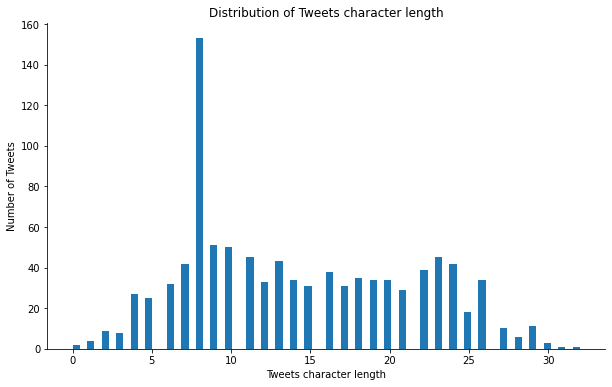

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in tweets_df_clean.text]
plt.hist(doc_lens, bins = 70)
plt.title('Distribution of Tweets character length')
plt.ylabel('Number of Tweets')
plt.xlabel('Tweets character length')
sns.despine();

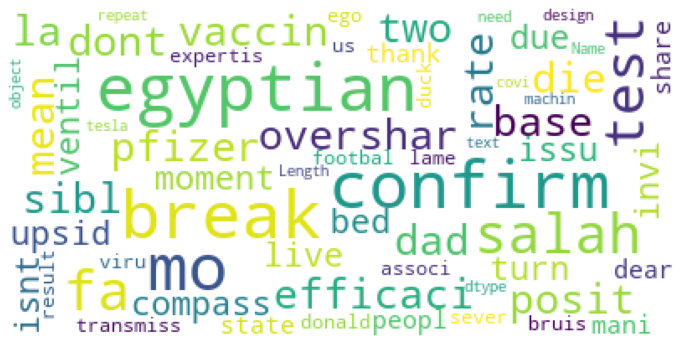

In [19]:
!pip install WordCloud
import matplotlib as mpl
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=100
                         ).generate(str(tweets_df_clean.text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# Flatten tweets
flat_list = [item for sublist in tweets_df_clean.text for item in sublist]

# CountVectorize
vectorizer = CountVectorizer(
analyzer='word',       
min_df=3,# minimum required occurences of a word 
stop_words='english',# remove stop words
lowercase=True,# convert all words to lowercase
token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
max_features=5000,# max number of unique words
                            )
data_matrix = vectorizer.fit_transform(flat_list)

In [23]:
# LDA
lda_model = LatentDirichletAllocation(
n_components=10, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix)

In [24]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  10.271902
9       0.648955  71.707100       2        1  10.118489
4      71.019684   9.971006       3        1  10.095639
5       3.785981  33.185135       4        1  10.076054
6     -42.666500  -9.222070       5        1  10.007508
7      -3.621689 -43.526516       6        1   9.953651
3      -3.632402  -4.171708       7        1   9.919376
2     -36.584400  35.804413       8        1   9.899792
8      44.391380  50.615383       9        1   9.885102
1      40.235809 -31.591665      10        1   9.772487, topic_info=         Term        Freq       Total Category  logprob  loglift
843      test  257.000000  257.000000  Default  30.0000  30.0000
619     posit  220.000000  220.000000  Default  29.0000  29.0000
724     salah  170.000000  170.000000  Default  28.0000  28.0000
271  egyptian  145.000000  145.000000  Default  27.0000  27.0000
166   confirm  131.000000  131.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
269       ego    9.172666    9.996690  Topic10  -4.6895   2.2396
94       best    9.088614    9.912638  Topic10  -4.6987   2.2388
827    survey    8.895035    9.719059  Topic10  -4.7202   2.2370
2       abort    8.365708    9.189732  Topic10  -4.7816   2.2317
318       flu    8.226925    9.050949  Topic10  -4.7983   2.2301

[330 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2        10  0.870537      abort
7         7  0.887414      accur
13        1  0.984765  administr
35        3  0.974261      alito
37        6  0.913530    alreadi
...     ...       ...        ...
940       1  0.939927     worker
941       5  0.915841      world
943       9  0.872021       wors
946       6  0.965760       year
951       4  0.972301      young

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 5, 6, 7, 8, 4, 3, 9, 2])

In [25]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['fraud', 'attend', 'bogus', 'liverpool', 'wed', 'restrict', 'rate', 'state', 'spread', 'administr']


Top 10 words for topic #1:
['rise', 'high', 'mortal', 'home', 'school', 'right', 'help', 'infect', 'today', 'vaccin']


Top 10 words for topic #2:
['chang', 'jail', 'famili', 'anoth', 'kill', 'final', 'say', 'die', 'peopl', 'case']


Top 10 words for topic #3:
['want', 'ppl', 'risk', 'pathet', 'defeat', 'week', 'wear', 'death', 'new', 'egyptian']


Top 10 words for topic #4:
['pfizer', 'thanksgiv', 'teacher', 'alito', 'way', 'exist', 'trump', 'moham', 'pandem', 'salah']


Top 10 words for topic #5:
['patient', 'work', 'lost', 'number', 'health', 'fight', 'mask', 'day', 'covid', 'break']


Top 10 words for topic #6:
['data', 'counti', 'person', 'texa', 'lose', 'instead', 'voter', 'dont', 'countri', 'posit']


Top 10 words for topic #7:
['doesnt', 'happen', 'care', 'small', 'year', 'communiti', 'virus', 'plan', 'problem', 'confirm']


Top 10 words for topic #8

# Hyperparameter Tuning

### Grid Search

In [26]:
from sklearn.model_selection import *

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_matrix)
GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128, 
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1, 
                                                 learning_decay=0.7, 
                                                 learning_method=None,
                                                 learning_offset=10.0, 
                                                 max_doc_update_iter=100, 
                                                 max_iter=10,
                                                 mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             iid=True, n_jobs=1,
             param_grid={'n_topics': [10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method=None,
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=1,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_

In [28]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_matrix))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -17117.530889266178
Model Perplexity:  852.8044897512298
